In [ ]:
import csv
import time
import pandas as pd
# Use svg backend for better quality
import matplotlib
import matplotlib.pyplot as plt
# from __future__ import print_function
# import sys
# print(sys.executable)

## Introduction

The following is a tutorial on 'how an individual can leverage data available over Twitter' and the kinds of analysis that we could perform such as mood classification, sentimenet analysis on a subject/discussion, geospatial analysis and other forms of intuitive visualisations for better communicating results to stakeholders. This is a growing feild of study and research by policy, psychology and science students.

There are several parts to this tutorial but largely we could divide them into three parts:
* Access Twitter API
    * Authentication (oauth2)
    * Pagination
    * Rate Limiting
* Simple Sentiment Analysis (using TextBlob)
* Geo-Spatial Analysis
* Download data [from my google drive (68 mb)](https://drive.google.com/open?id=10s9Ldj_gawj_DC5UZhWCbebjPeK2KqXW)

We will explore the varrious methods we could use to extract data from 'Twitter' and discuss the Pros & Cons of each.

(**Note:** references used to develp code chunks would be provided above the chunk along with description)

## Authentication

Most large web scale companies use a combination of authentication and rate limiting to control access to their data to ensure that everyone using it abides. Twitter uses the oauth2 authentication and hence we will go forward to apply for a developer account.

## Twitter API Access

1. Create a Twitter Account (if you dont have one already)
2. Go [here](https://apps.twitter.com/app/new) and log in. 
3. In 'Application Management' - 'Create an Application'. Enter 'Name', 'Description' & 'Website' (can be dummy)

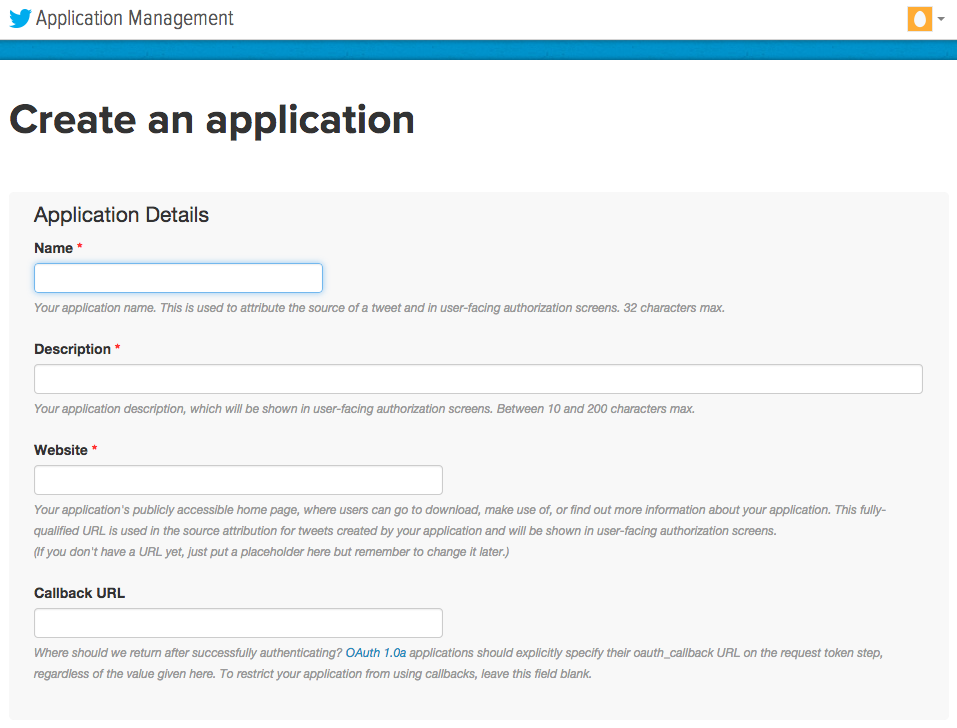

4. Accept the Terms of Service and Create the application
5. Go to 'Keys and Access Tokens'. Scroll down and select 'Create my Access Tokens' to get the Access key and Secret as well

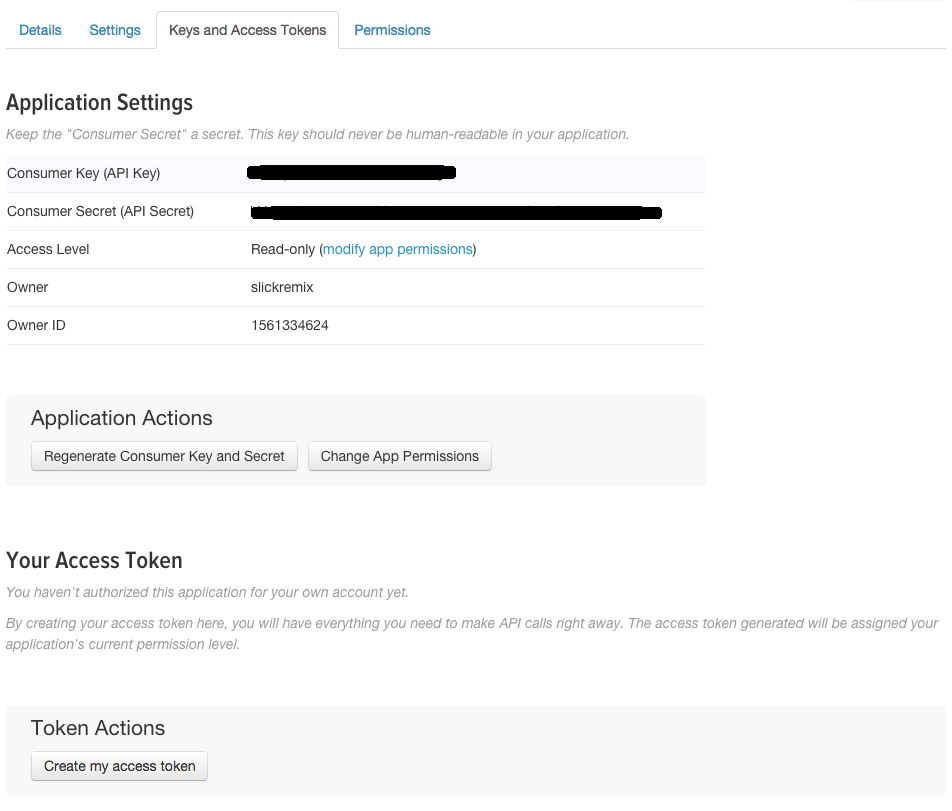

* Save the keys in four files one for each (as whoen below) and access them using the below function:

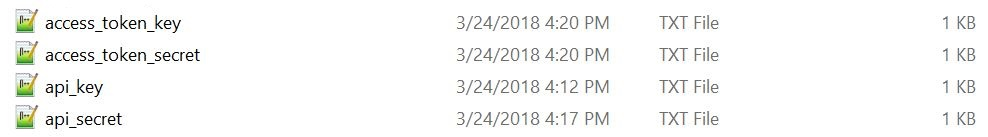

In [ ]:
def read_api_key(filepath1, filepath2, filepath3, filepath4):
    """
    Read the Twitter API Key information from file.
    Args:
        4 filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
        api_secret (string): The API Secret
        access_token_key (string): The Access Token Key
        access_token_secret (string): The Access Token secret
        
    """
    with open(filepath1, 'r') as f:
        api_key = f.read().replace('\n','')
    with open(filepath2, 'r') as f:
        api_secret = f.read().replace('\n','')
    with open(filepath3, 'r') as f:
        access_token_key = f.read().replace('\n','')
    with open(filepath4, 'r') as f:
        access_token_secret = f.read().replace('\n','')
    return (api_key, api_secret, access_token_key, access_token_secret)     
    
api_key, api_secret, access_token_key, access_token_secret = read_api_key("api_key.txt", "api_secret.txt", 
                                                                          "access_token_key.txt", "access_token_secret.txt")

## Twitter API

We will first explore 'Twitter' by simply exploring the **request** library. The procedure is as mentoined below:
* First 'API key & secret' and encode in the ASCII  format
* Use the **base64** library to encode the the key.
* Authorization in the 'headers' parameters where we pass this encoded key (along with some other parameters).
* Check for Status (200 OK) and keys that we can use from data response (access_token).
* Extract the tweets
* Our observations from 'studying the tweets'

Source:

[References 1](https://speca.io/speca/twitter-rest-api-v1.1)

(**Note:** This is a simple User Authentication that permits 180 requests per 15 mins and maximum 100 tweets per each)

In [ ]:
import oauth2 as oauth
import base64
import requests
import json

In [ ]:
key_secret = '{}:{}'.format(api_key, api_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [ ]:
url = '{}oauth2/token'.format('https://api.twitter.com/')

headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}

data = {
    'grant_type': 'client_credentials'
}

auth_resp = requests.post(url, headers=headers, data=data)
print('Status Code (check) : ',auth_resp.status_code)
print('Keys in data response : ', auth_resp.json().keys())

### Lets Extract tweets:

* Simply re-use the tokens access tokens as in above. Here the **json** library can be put to work.
* Create a 'Search Parameter' with the following keys:
    * 'search query' as 'facebook'
    * 'language' as 'en' (ISO format)
    * 'result' as 'popular' (can be 'mixed' or 'recent' as well)
    * 'count of tweets' as 5 (to sample, maximum can be 100)

In [ ]:
access_token = auth_resp.json()['access_token']
search_headers = {
    'Authorization': 'Bearer {}'.format(access_token)    
}

search_params = {
    'q': 'facebook',
    'lang': 'en',
    'result_type': 'popular',
    'count': 5
}

url = '{}1.1/search/tweets.json'.format('https://api.twitter.com/')

search_resp = requests.get(url, headers=search_headers, params=search_params)
tweet_data = search_resp.json()
for x in tweet_data['statuses']:
    print(x['text'])
    print(" ------------------------------ ")

### Observation from exploring tweets

We can observe the following:
* Several tweets are not being able to process and are getting cut-out from the text
* Once we save this text on-to a csv like file several white spaces (tabs, newlines, etc.) will ruin the formatting of our table
* There is alot of noise in our text like emoticons, links, hastags, slangs etc.
* There are a few caveats to pagination, rate limiting and ultimately authentication (user & application) that make a difference to the way we approach the problem

## Access Twitter using 'Tweepy' 

As we have discussed above 'user authentication' has its own limitations. "Tweepy" is a well known twitter library that has been developed which will increase the request to 450 per 15 minuites. It gives fexibillity to user to better manage **pagination** & **rate limiting** (wait_on_rate_limit & wait_on_rate_limit_notify). It returns a simple json, that can be easily parsed and information can be extracted.

We would like to attempt to access twitter using 'tweepy' and extract a small sample of 5 tweets to analyse its working. Also, get the 'full text' of the tweet and not use incomplete tweets going forward.



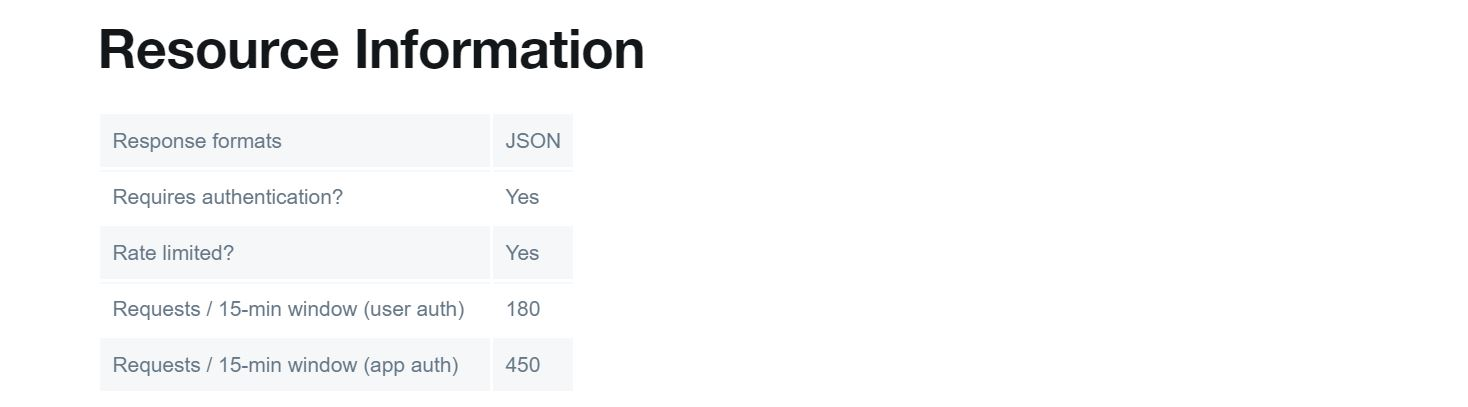

Source:

[Reference 1](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets)

In [ ]:
import tweepy
from tweepy.streaming import StreamListener
from tweepy import Stream
from tweepy import OAuthHandler

In [ ]:
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
fetched_tweets = api.search(q = 'facebook', lang='en', tweet_mode="extended", show_user=True, count = 5)
for one_tweet in fetched_tweets:
    print(one_tweet.full_text)
    print(" ----------------- ")

### Observation from exploring tweets

We can observe the following:
* Manage 'retweeted tweets',as they are incomplete even after using (tweet_mode='extended')
* We still need to clean the text for our csvfile (tabs, newlines, etc., which might ruin the formatting of our table)
* There is still alot of noise in our text like links, hastags, punctuations etc.

Lets create the following:
* Cleaning tweets function
* Code that maintain retweets as well and saves everything (along with screen name, coordinates and location) to a csv file 

In [ ]:
import re
import string

def clean_my_tweets(text_tweet):
    # convert into lower space
    check_text = text_tweet.lower()
    # strip /n from the lines in the text
    check_text = check_text.strip()
    # replace - with spaces
    new_str = check_text.replace("-", " ")
    # replace 's with null
    new_str = new_str.replace("'s", "")
    # replace ' with blank
    new_str = new_str.replace("'", "")
    # replace " with blank
    new_str = new_str.replace('"', "")
    # replace . with blank (beacuse countries are sometimes abbreviated using the same)
    new_str = new_str.replace('.', "")
    # remove mentions such as @realdonaltrump
    new_str = re.sub(r"@[\w]+", " ", new_str)
    # remove hashtags such as #deletefacebook
    new_str = re.sub(r"#[\w]+", " ", new_str)
    # remove urls such as https://t.co/nxIgrc3hdi
    new_str = re.sub(r"http\S+", " ", new_str)
    # replace any punctuation using import string.punctuation also removes special charachters
    for c in string.punctuation:
        new_str = new_str.replace(c, " ")
    # replace all types of white spaces : matches any whitespace character \r \n \t \f \v
    text_content = re.sub(r"\s+", " ", new_str)
    return text_content


Run the below test cases for tweets (cleaning them)

In [ ]:
# print(clean_my_tweets("*On, Facebook* --- ' ~!@#$%^&*`_+=;|  oianc's \n \n Girl : Tell me something that I don't know."))
# print(clean_my_tweets("https://t.co/nxIgrc3hdi oianc's \n \n @realdonaltrump : Tell me something that I don't know. "))
# print(clean_my_tweets("#deletefacebook Tell me I'm confused, What to do ... ???  https://t.co/nxIgrc3hdi "))
# print(clean_my_tweets("""zuckerberg so we censor conservatives, regulate me ... https://t.co/ois0endefq right 
#             facebook = dashboard for cia/nsa, cambridge analytics junk, but good  left hrc &amp; bho. #qanon right, fb value 
#             heads down, down @realdonaldtrump https://t.co/lsk6klryll"""))
print(clean_my_tweets("""mark zuckerberg new the power of facebook. we know immigrants/cannot legally participate in the  
             election process, (ask foxnews about mexican immigrants) zuck offered the  whole emotion changing ad  
             campaign machine to the russian/u.k./mercers analytics. peanut money for a coup https://t.co/0nbbnswsry"""))

## Tweepy 'Cursor' versus 'Search'

Tweepy has three functionalities to extract data:
* Cursor
* Search
* Stream Listner

### Tweepy 'Cursor'

The cursor is a newly implemented functionality and so I wanted to try it out once with a small sample of tweets to search for.

Apply the **retweeted check** and accordingly display the full text

Apply **cleaning** before displaying the tweet

In [ ]:
search_terms = '#deletefacebook OR facebook OR Mark Zuckerberg OR Zuckerberg'
counter = 0

# save in a csv file
with open('facebook_related_tweets_cursor.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'tweet_text', 'coordinates'])
    # use the Search API (api.search) in cursor
    for tweet in tweepy.Cursor(api.search, q=search_terms, lang="en", tweet_mode="extended").items(5) : # return 5 tweets        
        counter = counter + 1
        # check for retweets
        if tweet.full_text[0:4] == 'RT @' and hasattr(tweet, 'retweeted_status'):
            cleaned_tweet = clean_my_tweets(tweet.retweeted_status.full_text)
            print(cleaned_tweet)
            writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.coordinates])
        else:
            cleaned_tweet = clean_my_tweets(tweet.full_text)
            print(cleaned_tweet)
            writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.coordinates])
        print(" ------------------ ")
    #Display how many tweets we have collected
    print("Downloaded {} tweets".format(counter))

## Start using Twitter to store in CSV

### Tweepy 'Search'

Although, **cursor** is a newer functionality and needs much lesser code. I will still go ahead and use the **search** functionality. We can see from our observation that the coordinates are very hard to find and require additional checks before they can be stored. in a csv file. Additionally we will also record and use the below parts in the code:
* Define the 'maximum number of tweets' that we wish to download
* Keep the 'number of tweets returned per query' constant (i.e. 100)
* Use **max_id** & **since_id** to keep a record of donwnloaded tweets and avoid any duplication
* Keep a delay timer, so as to avoid rate limit
* store the query in the csv file with the additional checks of **retweet_status** & **coordinates** 

                                   "tweet -- coordinates -- coordinates"
                                   
* Search for 1 Million Tweets (as max number of rows of a csv file is 1,048,576)


Source: 
* [Reference 1](https://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./)
* [Reference 2](http://www.dealingdata.net/2016/07/23/PoGo-Series-Tweepy/)

**Note on Since_ID:** If results from a specific ID onwards are reqd, set since_id to that ID. Else default to no lower limit, go as far back as API allows.

**Note on Max_ID:** If results only below a specific ID are, set max_id to that ID. Else default to no upper limit, start from the most recent tweet matching the search query.

In [ ]:

# search_terms = 'facebook'
# search_terms = 'Mark Zuckerberg'
# search_terms = '#deletefacebook'
# search_terms = 'Cambridge Analytica'
search_terms = 'facebook OR Mark Zuckerberg OR #deletefacebook OR Cambridge Analytica'

maxTweets = 1000 
tweetsPerQry = 100  

sinceId = None
max_id = -1
tweetCount = 0
counter = 0
query_per_sec = 15*60/180.0  #180 per 15 minutes just to be safe as we know that we have 450 per 15 minuites

# store in a csv file
with open('facebook_related_tweets_search.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'tweet_text', 'location',
                              'lat_coord', 'lon_coord'])
    # also include location information
    while tweetCount < maxTweets:
        last_update = 0
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed')
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1), since_id=sinceId)
            # sleep / delay to avoid rate limit
            time.sleep(query_per_sec) 
            if not new_tweets:
                print("No tweets left to search for !")
                break
            # save in csv file
            for tweet in new_tweets:
                counter = counter + 1
                # condition to manage missing coordinates
                if tweet.coordinates is not None:
                    pri_XY_coord = [tweet.coordinates['coordinates'][0], tweet.coordinates['coordinates'][1]]
                else:
                    pri_XY_coord = ['','']
                # condition to manage retweets
                if tweet.full_text[0:4] == 'RT @' and hasattr(tweet, 'retweeted_status'):
                    cleaned_tweet = clean_my_tweets(tweet.retweeted_status.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              pri_XY_coord[1], pri_XY_coord[0]])
                else:
                    cleaned_tweet = clean_my_tweets(tweet.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              pri_XY_coord[1], pri_XY_coord[0]])
            # for countdown
            tweetCount = tweetCount + len(new_tweets)
            print("Countdown {} (downloaded {})".format(maxTweets-tweetCount, tweetCount))
            max_id = new_tweets[-1].id
        # exception erro catch
        except tweepy.TweepError as e:
            # Just exit if any error
            print("Exception caught (error) : " + str(e))
            break

# The Coordinates problem

Coordinates are extreemly hard to find for the tweets as the users have not shared or geo-tagged their tweets hence we need to take another feild that would be better in terms of obtaining the latitude and Longitude. In the above chunk of code we are recording the coordinates of the geo-tagged tweets, where the user tags the tweet by enabling and sharing the location. We will continue to record these coordinates but as our **secondary lat & long**. 

In the below chuck we are going to record those tweets where the users have enabled their location, which can be seen by:

                            "tweet -- place -- bounding box -- coordinates"

This gives us a bounding box, where we will apply a calculation to get the center and save the coordinates of those as our **primary lat & long**.

* Total number of tweets found related to our search terms : **362,753**
* Total number of primary coordinates found: **1195**
* Total number of secondary coordinates found: **50**

Hence, the decision to select the 'bounding box' feild was a much better one than simple 'coordinates'.

In [ ]:
search_terms = 'facebook OR Mark Zuckerberg OR #deletefacebook OR Cambridge Analytica'

maxTweets = 1000000 # 1 Milloin tweets
# maxTweets = 1000 # 1 Milloin tweets
tweetsPerQry = 100  
sinceId = None
max_id = -1
tweetCount = 0
counter = 0
query_per_sec = 15*60/180.0  #180 per 15 minutes just to be safe as we know that we have 450 per 15 minuites

# save data in csv file
with open('facebook_related_tweets_final.csv', 'w', newline='', encoding='utf-8') as csvFacebook:
    writer_facebook = csv.writer(csvFacebook, delimiter=',')
    writer_facebook.writerow(['row_id', 'screen_name', 'tweet_text', 'location',
                              'lat_coord', 'lon_coord', 'lat_box_coord', 'lon_box_coord'])
    # added primary and secondary coordinates along with location of the user
    while tweetCount < maxTweets:
        last_update = 0
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed')
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=search_terms, count=tweetsPerQry, lang="en", tweet_mode="extended", 
                                            result_type='mixed', max_id=str(max_id - 1), since_id=sinceId)
            # sleep / delay to avoid rate limiting
            time.sleep(query_per_sec) 
            if not new_tweets:
                print("No tweets left to search for !")
                break
            # save in csv file
            for tweet in new_tweets:
                counter = counter + 1
                # condition to manage missing primary coordinates
                if tweet.place is not None:
                    bound_box_tweet = tweet.place.bounding_box.coordinates[0]                                    
                    pri_XY_coord = [(bound_box_tweet[0][0] + bound_box_tweet[2][0])/2, 
                          (bound_box_tweet[0][1] + bound_box_tweet[2][1])/2]
                else:
                    pri_XY_coord = ["",""]
                # condition to manage missing secondary coordinates
                if tweet.coordinates is not None:
                    sec_XY_coord = [tweet.coordinates['coordinates'][0], tweet.coordinates['coordinates'][1]]
                else:
                    sec_XY_coord = ['','']
                # condition to manage retweets
                if tweet.full_text[0:4] == 'RT @' and hasattr(tweet, 'retweeted_status'):
                    cleaned_tweet = clean_my_tweets(tweet.retweeted_status.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              sec_XY_coord[1], sec_XY_coord[0], pri_XY_coord[1], pri_XY_coord[0]])
                else:
                    cleaned_tweet = clean_my_tweets(tweet.full_text)
                    writer_facebook.writerow([counter, tweet.author.screen_name, cleaned_tweet, tweet.user.location,
                                              sec_XY_coord[1], sec_XY_coord[0], pri_XY_coord[1], pri_XY_coord[0]])
            # countdown the downloaded tweets
            tweetCount = tweetCount + len(new_tweets)
            print("Countdown {} (downloaded {})".format(maxTweets-tweetCount, tweetCount))
            max_id = new_tweets[-1].id
        # error exception catching
        except tweepy.TweepError as e:
            # Just exit if any error
            print("Exception caught (error) : " + str(e))
            break

## Using Classifier for Sentiment Analysis

Sentiment Analysis requires a dataset to "train" and test. We can perform the same using Python's 'textblob' library. TextBlob contains a labeled dataset with movie reviews, where the labels are 'positive' or 'negative'. We will try out different classifiers to classify the tweets from the users. Ultimately we should be able to associate the users having positive or negative views on the topics that we have searched.

In [ ]:
from textblob import TextBlob
classify_tweets = pd.read_csv('facebook_related_tweets.csv')

In [ ]:
clean_classify_tweets = pd.np.array(classify_tweets.tweet_text)
tweet_text_list = [i for i in clean_classify_tweets] 

sentiment = []
# print(len(tweet_text_list), type(tweet_text_list))
for tweet in tweet_text_list:
    # use TextBlob object to analyse tweet text
    analyse_my_sentiment = TextBlob(tweet)
    # create a sentiment
    if analyse_my_sentiment.sentiment.polarity > 0:
        sentiment.append('positive') 
    elif analyse_my_sentiment.sentiment.polarity == 0:
        sentiment.append('neutral')
    else:
        sentiment.append('negative')

# print(sentiment)


In [ ]:
import collections
ctr = collections.Counter(sentiment)
for i in ctr.keys():
    percent_calc = float(ctr[i]) / float(sum(ctr.values())) * 100
    print("The percentage of {} tweets : {}% (total number of tweets {})".format(i, round(percent_calc,2), ctr[i]))

Some insights can be interesting such as there is still positive number of opinions even after such an event for 'Facebook'.

**Note:** Apologies, due to lack of time I have been unable to merge the sentiment analysis with geo-spatial analysis. Also, I had initially planned to create my own NLP processor for the sentiment analysis but again had to use an already existing one (other caveats like managing stop words in the tweets etc. has not been performed).

## Geo-Spatial Analysis of the tweets

Even after collecting information from different sources within the JSON string accessing the Twitter API we were unable to track location of only 3.3 % of the tweets downloaded. This problem has been documented several places where researchers studying people behaviour have to take measured steps to sample the data available.

We are going to read from our data in the final tweets file and only plot those instances of tweets for which we have the coordinates.

* Standard Library for Geo-Spatial analysis
    * [mpl_toolkits.basemap](https://matplotlib.org/basemap/users/installing.html)
    
First we need to clean and get rid of the 'NAN' values and use the 1195 observations (tweets) which have a location, the dataframe will look something like below and we will leverage the **pandas read_csv** for the same.


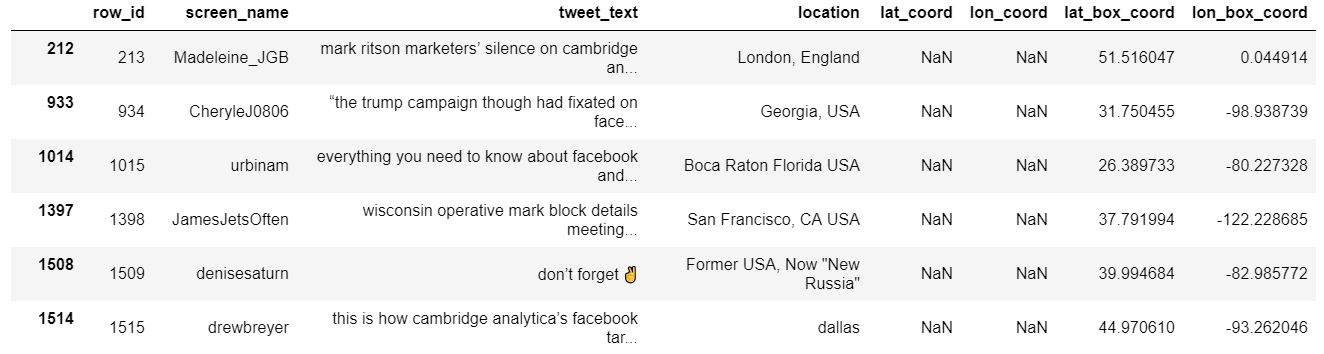

In [ ]:
building_map = pd.read_csv('facebook_related_tweets.csv')
# print(building_map.head(5))
print(building_map.shape)

In [ ]:
cleaned_building_map = building_map.dropna(subset = ['lat_box_coord', 'lon_box_coord'])
print(cleaned_building_map.shape)
# print(cleaned_building_map.head(5))

Now we need to convert the pandas dataframe into a list for the Latitude and Longitude. This is a requirement as the basemap uses list as data structures for its values. The following steps in the process are fairly simple:
    
   * Define the minimum and maximum lattude and longitude for the boundaries (with a margin if required)
   * create a Basemap: 
       * Center of the map
       * Resolution = full or high (others options like crude, low, intermediate)
       * Projection as 'Mercator' [other projections](https://matplotlib.org/basemap/users/mapsetup.html)
   * Draw Coastlines, Countries, States, Map boundaries and fill with colors in the map
   * Converting (lat & lon) to map projection coordinates
   * Plot the figure of a certain size by passing the parameters along with lat, long


Source: 
* [Reference 1](https://stackoverflow.com/questions/44488167/plotting-lat-long-points-using-basemap)
* [Reference 2](http://www.datadependence.com/2016/06/creating-map-visualisations-in-python/)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# lat = cleaned_building_map.lat_box_coord
location_data = cleaned_building_map.iloc[:, -2:].copy()
clean_location_data = pd.np.array(location_data)
lat = [i[0] for i in clean_location_data] 
lon =  [i[1] for i in clean_location_data] 
# print(len(lat), type(lat), type(lon))

In [ ]:
# determine range to print based on min, max lat and lon of the data
margin = 10 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

fig, ax = plt.subplots(figsize=(20,35))

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'f',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
plt.show()
fig.savefig('my_graph_image.png')

### Will capture the below image:

We can clearly see high activity in countries affect by this event of cmabridge analytics namely **United States**, **UK**, **India**, **Singapore** and other locations as well.

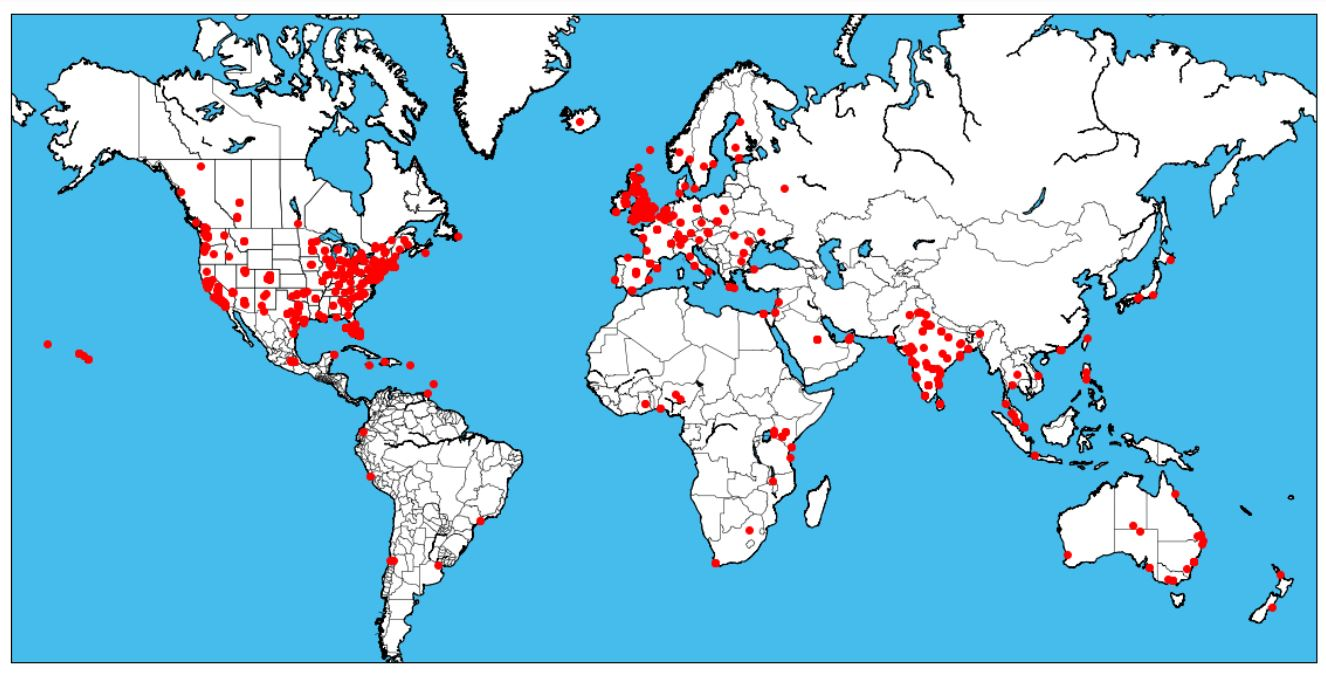

## Future Work

Major functions that are needed to be included:
* Create a geo-coder for the 'location' feild that we have saved (if we can get more coordinates to plot from users account location)
* Create our own text classifier
* Merge sentiment analysis with geo-spatial analysis